In [1]:
'''
import library 
'''
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import scipy as sc
from helpers import interp2
%matplotlib inline

In [4]:
# !pip3 install -U opencv-contrib-python==3.4.2.17
import cv2

In [5]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
    """
    compute the homography transform
    p1, p2: 4 x 2, 4 groups of corresponding points
    """	
    # IMPLEMENT HERE, hint: you may find np.linalg.svd useful

    # construct the A matrix in the same way in the slides
    A = np.array([[p2[0,0],p2[0,1],1,0,0,0,-p2[0,0]*p1[0,0],-p2[0,1]*p1[0,0], -p1[0,0]],
                 [0,0,0,p2[0,0],p2[0,1],1,-p2[0,0]*p1[0,1],-p2[0,1]*p1[0,1], -p1[0,1]],
                 [p2[1,0],p2[1,1],1,0,0,0,-p2[1,0]*p1[1,0],-p2[1,1]*p1[1,0], -p1[1,0]],
                 [0,0,0,p2[1,0],p2[1,1],1,-p2[1,0]*p1[1,1],-p2[1,1]*p1[1,1], -p1[1,1]],
                 [p2[2,0],p2[2,1],1,0,0,0,-p2[2,0]*p1[2,0],-p2[2,1]*p1[2,0], -p1[2,0]],
                 [0,0,0,p2[2,0],p2[2,1],1,-p2[2,0]*p1[2,1],-p2[2,1]*p1[2,1], -p1[2,1]],
                 [p2[3,0],p2[3,1],1,0,0,0,-p2[3,0]*p1[3,0],-p2[3,1]*p1[3,0], -p1[3,0]],
                 [0,0,0,p2[3,0],p2[3,1],1,-p2[3,0]*p1[3,1],-p2[3,1]*p1[3,1], -p1[3,1]]])
    
    # use SVD to find the solution to Ax = 0
    u, s, vh = np.linalg.svd(A)
    
    # reorgnize the solution vector and normalize it to get homography matrix
    v = vh.T
    h = v[:,-1]/v[-1,-1]
    H = h.reshape(3,3)
    return H

In [6]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [7]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [9]:
'''
Function (modify)
'''
def match_features(f1,f2):
    """
    f1, f2: N * feature_size, two features to be matched
    """

    # IMPLEMENT HERE
    # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful

    # compute pairwise distance between f1 and f2
    d = cdist(f1,f2)
    threshold = 0.7

    # forward matching, find closet two matches in f2 to f1 and do a ratio test
    f1_f2_sort  = np.argsort(d, axis=1)[:,0:2] #Sort indices in ascending order of distances
    f1_f2_d1 = np.take_along_axis(d, f1_f2_sort[:,0:1],axis=1) #Get the distances associated with first index
    f1_f2_d2 = np.take_along_axis(d, f1_f2_sort[:,1:2],axis=1) #Get the distances associated with second index
    f1_f2_ratio = f1_f2_d1/f1_f2_d2 #Calculate the ratio
    f1_f2_result = (f1_f2_ratio < threshold).nonzero()[0] #Get the indices which are valid
    f1_f2_sno = np.arange(d.shape[0]).reshape(d.shape[0],1) #Get the sno for every point in f1
    f1_f2_indices = f1_f2_sort[:,0:1] #Get the list of first indices
    f1_f2_final = np.concatenate((f1_f2_sno, f1_f2_indices),axis=1)[f1_f2_result] #Concatenate only for valid indices
    

    # backward matching, find closet two matches in f1 to f2 and do a ratio test
    f2_f1_sort  = np.argsort(d, axis=0) #Sort indices in ascending order of distances
    f2_f1_d1 = np.take_along_axis(d, f2_f1_sort[0:1,:],axis=0) #Get the distances associated with first index
    f2_f1_d2 = np.take_along_axis(d, f2_f1_sort[1:2,:],axis=0) #Get the distances associated with second index
    f2_f1_ratio = f2_f1_d1/f2_f1_d2 #Calculate the ratio
    f2_f1_result = (f2_f1_ratio < threshold).nonzero()[1] #Get the indices which are valid
    f2_f1_sno = np.arange(d.shape[1]).reshape(1,d.shape[1]) #Get the sno for every point in f2
    f2_f1_indices = f2_f1_sort[0:1,:] #Get the list of first indices
    f2_f1_final = np.concatenate((f2_f1_indices, f2_f1_sno),axis=0).transpose()[f2_f1_result] #Concatenate only for valid indices

    # get the intersect of two matching as the final result, python set
    intersect = set(map(tuple, f1_f2_final)) & set(map(tuple, f2_f1_final))
    res = np.array(list(intersect))

    return res, f1_f2_final, f2_f1_final

In [10]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

[ WARN:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-r0utbq5z/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (15) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


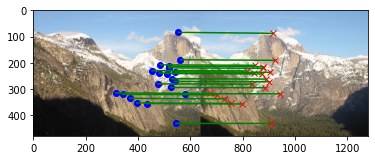

In [11]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [12]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
    """
      p1, p2: N * 2, correponding point coordinates
    """
  
  # decide how many loops to run and what the threshold is
    #Calculate the number of iterations
    w = 0.5
    p = 1 - 1e-4
    n = 4
    k = int(np.log(1-p)/np.log(1 - np.power(w,n)))
    
    #Set threshold
    t = 0.5

    #
    best_inliers_count = 0
    best_H = None

  # RANSAC loop, inside in the loop
    inliers_count = 0
    i = 0
    while(inliers_count < p1.shape[0]*0.7):
  #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
        random_choices = np.random.choice(p1.shape[0],n).reshape(n,1)
        p11 = np.take_along_axis(p1, random_choices, axis=0)
        p22 = np.take_along_axis(p2, random_choices, axis=0)

  #     2a. fit the model and get a estimation
        H = compute_homography(p11, p22)
    
    
  #     2b. calculate the new according to H
        p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T
        p1_ = H @ p2_
        p1_ = p1_ / p1_[-1, :]
        p1_ = p1_[:2]
        p1_ = p1_.T

  #     3. count consensus(# of inliners that is close to the estimation within the threshold)
        dist = (p1_ - p1)**2
        dist = np.sum(dist, axis=1)
        dist = np.sqrt(dist)
        inliers_count = np.count_nonzero(dist < t)
        

  #     4. update the best estimation if the current one is better 
        if(inliers_count > best_inliers_count):
            best_H = H
    return best_H

In [13]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

In [18]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """

    # map I2 to I1
    nr_orig = I2.shape[0]
    nc_orig = I2.shape[1]

    x_orig,y_orig = np.meshgrid(np.arange(nc_orig),np.arange(nr_orig))

    #applying homography on for I2
    x_i2_h = H[0,0]*x_orig + H[0,1]*y_orig + H[0,2]
    y_i2_h = H[1,0]*x_orig + H[1,1]*y_orig + H[1,2]
    z_i2_h = H[2,0]*x_orig + H[2,1]*y_orig + H[2,2]

    x_i2_h = x_i2_h/z_i2_h
    y_i2_h = y_i2_h/z_i2_h

    #converting indices to int
    x_i2_h = x_i2_h.astype(int)
    y_i2_h = y_i2_h.astype(int)


    #fix the offsets to find size of final image
    offset_x = 0
    offset_y = 0
    if(x_i2_h.min() < 0):
        offset_x = int(abs(x_i2_h.min()))
    if(y_i2_h.min() < 0):
        offset_y = int(abs(y_i2_h.min()))

    #larger image size
    nr_p = max([(y_orig + offset_y).max(),(y_i2_h + offset_y).max()]) + 1
    nc_p = max([(x_orig + offset_x).max(),(x_i2_h + offset_x).max()]) + 1

    #Creacting enlarged images 
    I_ = np.zeros((nr_p,nc_p,3), dtype='uint8')
    
    I1_  = np.zeros((nr_p,nc_p,3), dtype='uint8')
    I1_[y_orig,x_orig] = I1
    
    I2_  = np.zeros((nr_p,nc_p,3), dtype='uint8')

    #finding the location where I2 should go
    x_i2 = x_orig + (nc_p-nc_orig)
    y_i2 = y_orig # no shift in y as the images are only right shifted


    #Performing inverse warping to the place where I2 should go
    H_inv = np.linalg.inv(H)

    x_i2_hinv = H_inv[0,0]*x_i2 + H_inv[0,1]*y_i2 + H_inv[0,2]
    y_i2_hinv = H_inv[1,0]*x_i2 + H_inv[1,1]*y_i2 + H_inv[1,2]
    z_i2_hinv = H_inv[2,0]*x_i2 + H_inv[2,1]*y_i2 + H_inv[2,2]

    x_i2_hinv = x_i2_hinv/z_i2_hinv
    y_i2_hinv = y_i2_hinv/z_i2_hinv


    #interpolation RGB to the location for I2
    # I2_warp = np.zeros((nr,nc,3), dtype='uint8')
    I2_[y_i2,x_i2,0]= interp2(I2[:,:,0], x_i2_hinv, y_i2_hinv)
    I2_[y_i2,x_i2,1]= interp2(I2[:,:,1], x_i2_hinv, y_i2_hinv)
    I2_[y_i2,x_i2,2]= interp2(I2[:,:,2], x_i2_hinv, y_i2_hinv)

    #translating the 2 images to the final image

    I_ = np.where(I1_==0, I2_, I_)
    I_ = np.where(I2_==0, I1_, I_)
    
    #averaging the common area
    I_ = np.where(I_==0, (I1_/2+I2_/2).astype('uint8'), I_)
    
    
    return I_

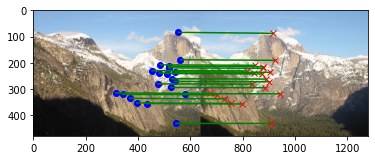

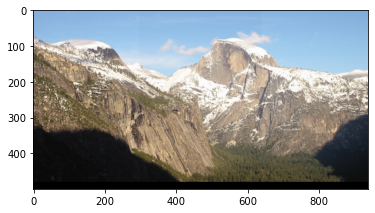

In [23]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)

plt.savefig("final_blended.png")
# plt.show()